# WSL xG analysis

In [6]:
from statsbombpy import sb
from utils.statsbomb_wrappers import Match, Season
import pandas as pd

import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, Pitch

In [2]:
competitions = sb.competitions()
competitions.loc[competitions["competition_name"] == "FA Women's Super League"]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
22,37,90,England,FA Women's Super League,female,False,False,2020/2021,2023-02-25T14:52:09.326729,2021-06-13T16:17:31.694,None,2023-02-25T14:52:09.326729
23,37,42,England,FA Women's Super League,female,False,False,2019/2020,2023-07-25T01:08:03.214566,2021-06-13T16:17:31.694,None,2023-07-25T01:08:03.214566
24,37,4,England,FA Women's Super League,female,False,False,2018/2019,2023-07-24T19:50:20.881595,2021-06-13T16:17:31.694,None,2023-07-24T19:50:20.881595


In [12]:
wsl_comp_id = 37
wsl_matches_20_21 = Season(competition_id=wsl_comp_id, season_id=90)

wsl_matches_20_21.get_matches().shape

(131, 22)

In [53]:
wsl_matches_20_21.matches["home_team"].unique().reshape((4,3))

array([['Aston Villa', 'Arsenal WFC', 'Brighton & Hove Albion WFC'],
       ['Chelsea FCW', 'Reading WFC', 'Manchester United'],
       ['Birmingham City WFC', 'Bristol City WFC', 'West Ham United LFC'],
       ['Everton LFC', 'Tottenham Hotspur Women', 'Manchester City WFC']],
      dtype=object)

In [64]:
def plot_shots_for_season(season, team):
    matches = pd.concat([season.get_matches(home_team=team),season.get_matches(away_team=team)] )
    shots = pd.concat([
        Match(match_id=match_id).get_events(type="Shot", team=team)
        for match_id in matches["match_id"]
    ])
    goals = shots.loc[shots["shot_outcome"] == "Goal"]
    
    pitch = Pitch()
    fig, ax = pitch.draw()

    ax.scatter(
            [shot[0] for shot in shots["location"].values],
            [shot[1] for shot in shots["location"].values],
            c=[xG for xG in shots["shot_statsbomb_xg"].values],
            s=0.5,
            cmap='rainbow',
        )

    ax.scatter(
            [goal[0] for goal in goals["location"].values],
            [goal[1] for goal in goals["location"].values],
            c=[xG for xG in goals["shot_statsbomb_xg"].values],
            s=15,
            cmap='rainbow'
        )
    
    ax.set_title(f"{team}, xG {sum(shots['shot_statsbomb_xg']):.2f}, goals/shots {len(goals)}/{len(shots)}")

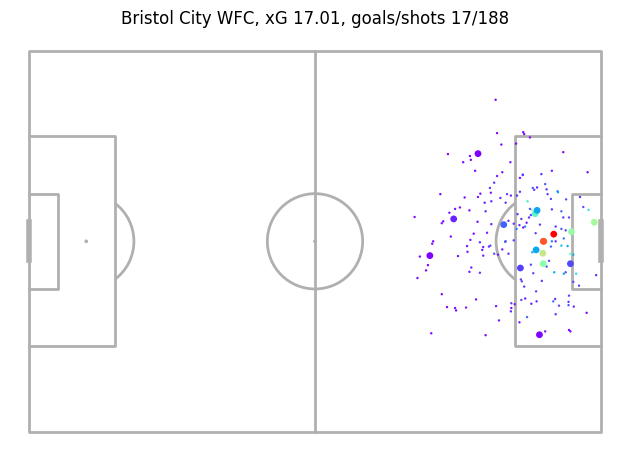

In [66]:
# teams = wsl_matches_20_21.matches["home_team"].unique()
teams = ["Bristol City WFC"]

for team in teams:
    plot_shots_for_season(wsl_matches_20_21, team)


In [23]:
shot = arsenal_shots.loc[3616]
shot.dropna()

duration                                                       0.698834
id                                 0ba83eaf-b15d-4879-9ee5-cba49421bd89
index                                                               278
location                                                  [109.4, 43.0]
match_id                                                        3775648
minute                                                                5
period                                                                1
play_pattern                                                From Corner
player                                                 Vivianne Miedema
player_id                                                       15623.0
position                                                      Left Wing
possession                                                           11
possession_team                                             Arsenal WFC
possession_team_id                                              

In [26]:
shot.shot_freeze_frame

[{'location': [115.7, 38.0],
  'player': {'id': 4657, 'name': 'Anita Amma Ankyewah Asante'},
  'position': {'id': 4, 'name': 'Center Back'},
  'teammate': False},
 {'location': [119.0, 40.9],
  'player': {'id': 38317, 'name': 'Lisa Weiß'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'teammate': False},
 {'location': [110.3, 36.4],
  'player': {'id': 10102, 'name': 'Stine Larsen'},
  'position': {'id': 24, 'name': 'Left Center Forward'},
  'teammate': False},
 {'location': [110.2, 42.8],
  'player': {'id': 46535, 'name': 'Natalie Haigh'},
  'position': {'id': 5, 'name': 'Left Center Back'},
  'teammate': False},
 {'location': [93.3, 26.1],
  'player': {'id': 25610, 'name': 'Mana Iwabuchi'},
  'position': {'id': 22, 'name': 'Right Center Forward'},
  'teammate': False},
 {'location': [117.4, 42.3],
  'player': {'id': 46537, 'name': 'Jodie Hutton'},
  'position': {'id': 8, 'name': 'Left Wing Back'},
  'teammate': False},
 {'location': [106.7, 28.8],
  'player': {'id': 46539, 'name': 

Text(0.5, 1.0, 'Shot by Vivianne Miedema, Half 1 minute 5, xG 0.046657536')

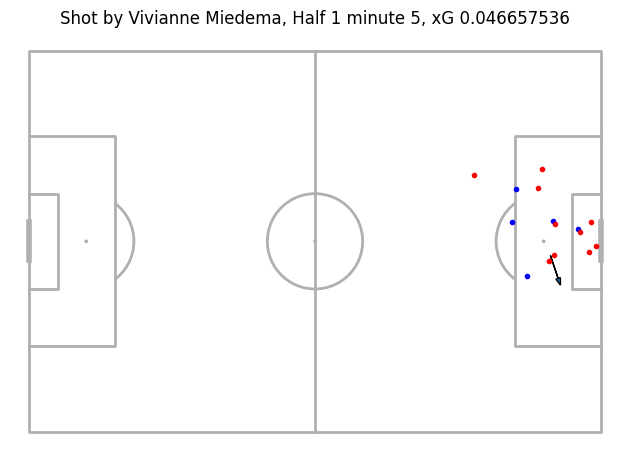

In [41]:
pitch = Pitch()
fig, ax = pitch.draw()

ax.plot(
    [player["location"][0] for player in shot.shot_freeze_frame if player["teammate"]],
    [player["location"][1] for player in shot.shot_freeze_frame if player["teammate"]],
    "b.",
)
ax.plot(
    [player["location"][0] for player in shot.shot_freeze_frame if not player["teammate"]],
    [player["location"][1] for player in shot.shot_freeze_frame if not player["teammate"]],
    "r.",
)

def plt_arrow(ax, start: tuple, end: tuple):
    ax.arrow(
        start[0],
        start[1],
        end[0] - start[0],
        end[1] - start[1],
        head_width=1,
        length_includes_head=True,
    )

plt_arrow(ax, shot["location"], shot["shot_end_location"])

ax.set_title(f"Shot by {shot.player}, Half {shot.period} minute {shot.minute}, xG {shot.shot_statsbomb_xg}")